In [ ]:
#!pip install albumentations

# Standard U-Net (Accuracy, BinaryCrossEntropy)

# Loading and preprocessing

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import tifffile as tiff
import albumentations as A

2024-07-14 19:46:00.141973: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 19:46:00.142076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 19:46:00.279850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
data_path = '/kaggle/input/electron-microscopy/EPFL electron microscopy'

In [5]:
def load_images_from_tiff(tiff_file):
    with tiff.TiffFile(tiff_file) as tif:
        images = tif.asarray()
    return images

#Resize and converting images to RGB
def preprocess_images(images, target_shape):
    if len(images.shape) == 3:
        images = images[..., np.newaxis]
    resized_images = np.array([tf.image.resize(image, target_shape[:2]).numpy() for image in images])
    if target_shape[2] == 3:
        resized_images = np.repeat(resized_images, 3, axis=-1)
    return resized_images

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=8, augmentations=None, shuffle=True):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augmentations = augmentations
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        self.on_epoch_end()

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_masks = self.masks[batch_indices]

        if self.augmentations:
            augmented = [self.augmentations(image=image, mask=mask) for image, mask in zip(batch_images, batch_masks)]
            batch_images = np.array([item[0] for item in augmented])
            batch_masks = np.array([item[1] for item in augmented])

        return batch_images, batch_masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [7]:
train_images = load_images_from_tiff('/kaggle/input/electron-microscopy/EPFL electron microscopy/training images/training.tiff')
test_images = load_images_from_tiff('/kaggle/input/electron-microscopy/EPFL electron microscopy/testing images/testing.tiff')
train_masks = load_images_from_tiff('/kaggle/input/electron-microscopy/EPFL electron microscopy/training groundtruth/training_groundtruth.tiff')
test_masks = load_images_from_tiff('/kaggle/input/electron-microscopy/EPFL electron microscopy/testing images/testing.tiff')


In [8]:
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_masks = train_masks.astype('float32') / 255.
test_masks = test_masks.astype('float32') / 255.

In [9]:
train_masks = (train_masks > 0.5).astype(np.float32)
test_masks = (test_masks > 0.5).astype(np.float32)

In [10]:
target_shape = (256, 256, 3)
train_images = preprocess_images(train_images, target_shape)
test_images = preprocess_images(test_images, target_shape)
train_masks = preprocess_images(train_masks, (256, 256, 1))
test_masks = preprocess_images(test_masks, (256, 256, 1))

In [11]:
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)


# Augmentation

In [12]:
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

def augment_image(image, mask):
    augmented = augmentations(image=image, mask=mask)
    return augmented['image'], augmented['mask']

In [13]:
batch_size = 8
train_generator = DataGenerator(train_images, train_masks, batch_size=batch_size, augmentations=augment_image)
validation_generator = DataGenerator(val_images, val_masks, batch_size=batch_size, augmentations=None)


# U-Net Model

In [14]:
#Standard U-Net Model with Dropout layers
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.2)(pool4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.2)(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = Dropout(0.2)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = Dropout(0.2)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = Dropout(0.2)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Dropout(0.2)(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

# Training

In [15]:
input_size = (256, 256, 3)
model = unet(input_size=input_size)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [16]:
checkpoint = ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_generator, epochs=50, validation_data=validation_generator, 
                    callbacks=[checkpoint, early_stopping], verbose=1)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-14 19:49:04.405097: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,192,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,192,256,256]{3,2,1,0}, f32[8,64,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-14 19:49:06.425500: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 3.020519559s
Trying algorithm eng0{} for conv (f32[64,1

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9054 - loss: 67.6072
Epoch 1: val_loss improved from inf to 0.58369, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 137s 664ms/step - accuracy: 0.9070 - loss: 65.7619 - val_accuracy: 0.9402 - val_loss: 0.5837
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9440 - loss: 0.4328
Epoch 2: val_loss improved from 0.58369 to 0.20931, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 569ms/step - accuracy: 0.9439 - loss: 0.4269 - val_accuracy: 0.9402 - val_loss: 0.2093
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9420 - loss: 0.2141
Epoch 3: val_loss improved from 0.20931 to 0.20247, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 574ms/step - accuracy: 0.9420 - loss: 0.2139 - val_accuracy: 0.9406 - val_loss: 0.2025
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9444 - loss: 0.1950
Epoch 4: val_loss improved from 0.20247 to 0.18740, saving mo

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


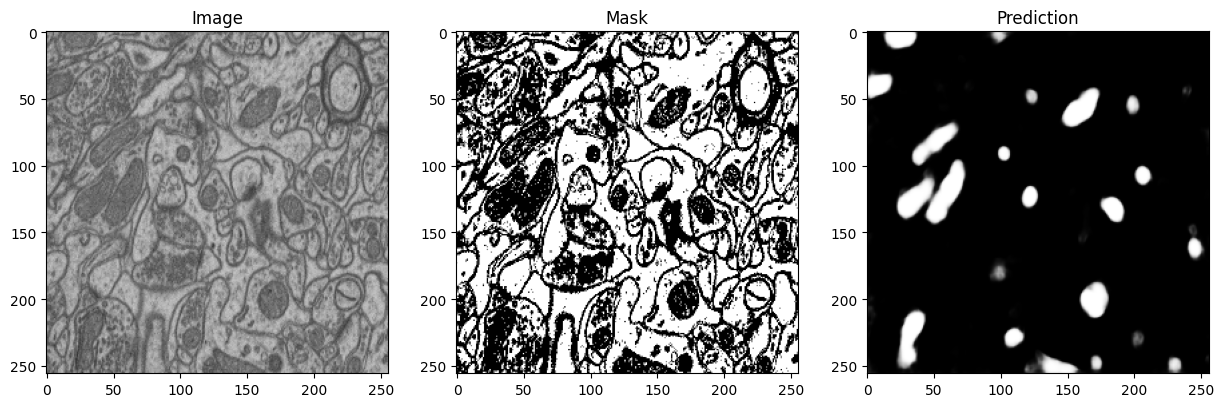

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


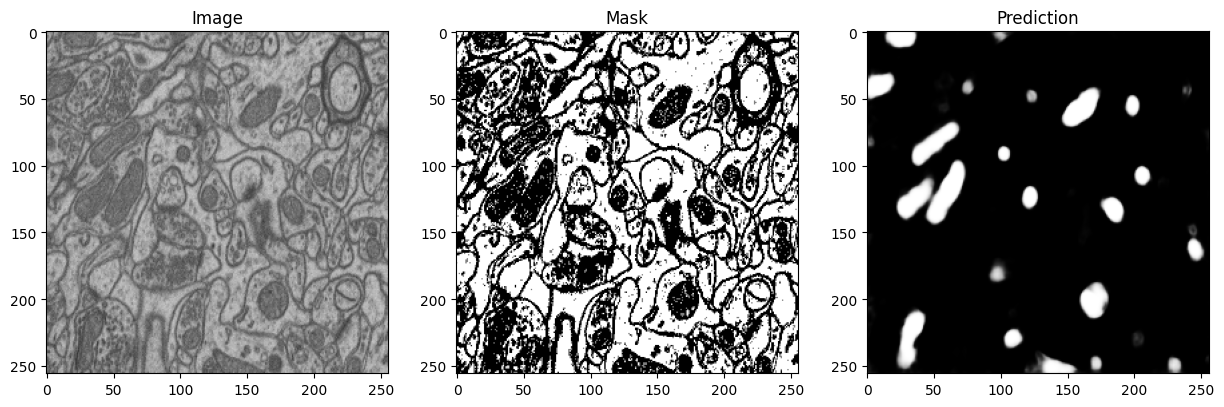

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


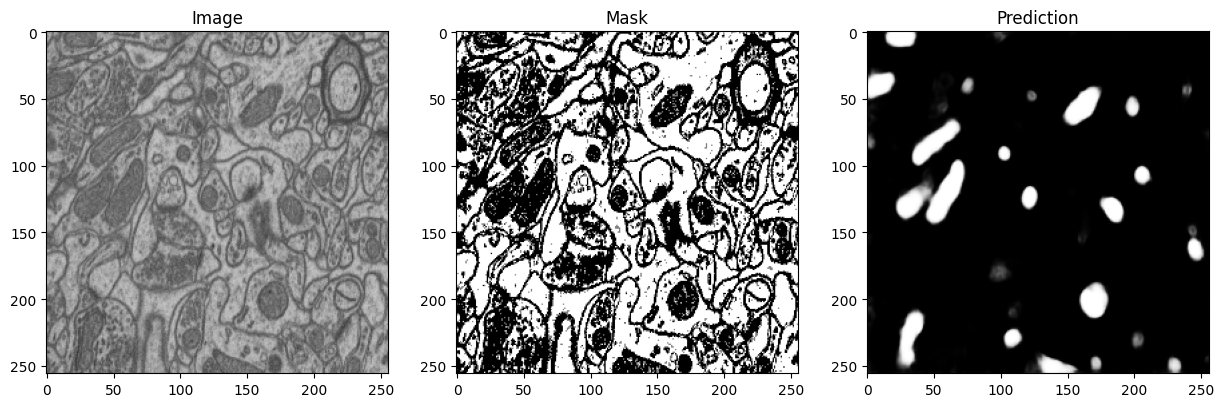

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


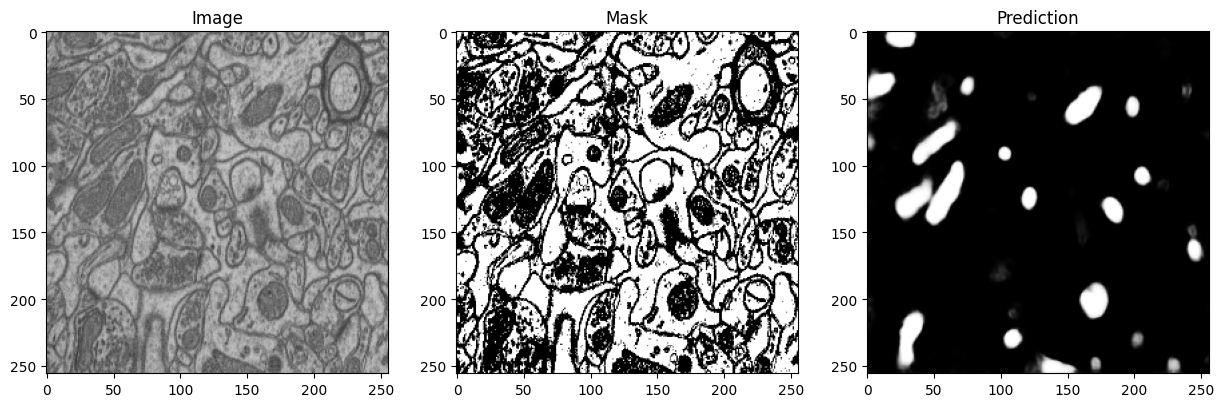

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


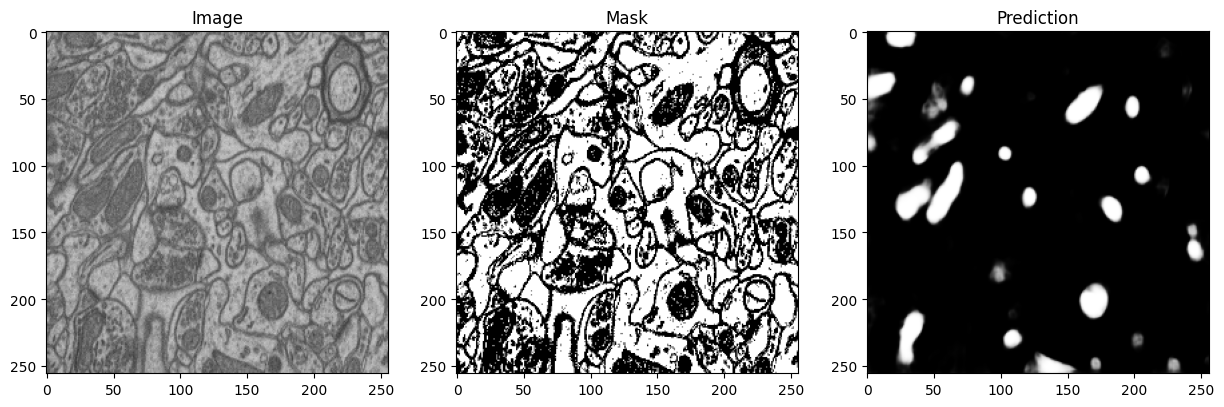

In [25]:
# Sample predictions
def plot_sample_predictions(images, masks, model, num_samples=5):
    for i in range(num_samples):
        image = images[i]
        mask = masks[i]
        prediction = model.predict(np.expand_dims(image, axis=0))[0]
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image.squeeze(), cmap='gray')
        ax[0].set_title('Image')
        ax[1].imshow(mask.squeeze(), cmap='gray')
        ax[1].set_title('Mask')
        ax[2].imshow(prediction.squeeze(), cmap='gray')
        ax[2].set_title('Prediction')
        plt.show()

plot_sample_predictions(test_images, test_masks, model)


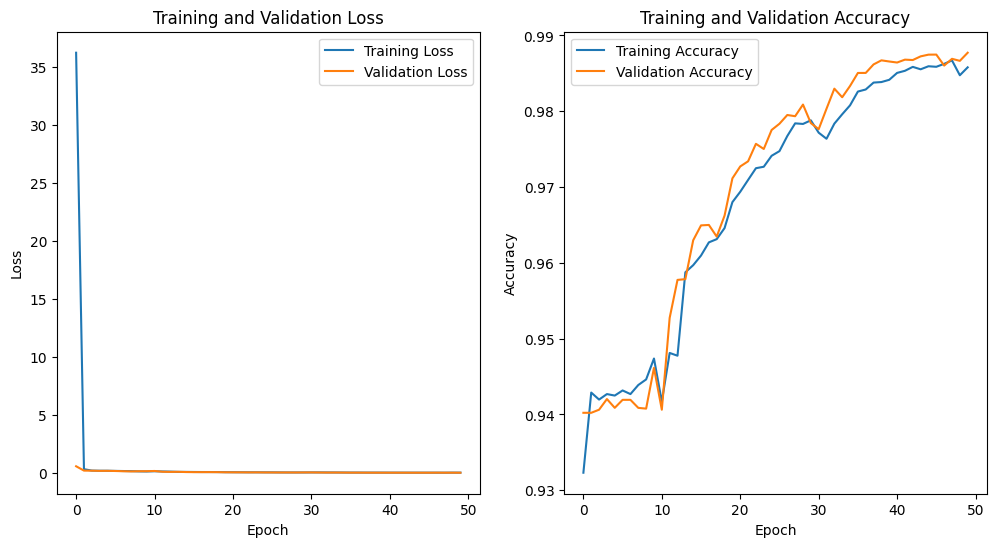

In [20]:
# Training history (loss and accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Standard U-Net (IoU Score, Jaccard Loss)

# Loading and preprocessing

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import tifffile as tiff
import albumentations as A

In [60]:
data_path = '/kaggle/input/electron-microscopy/EPFL electron microscopy'

In [62]:
def load_images_from_tiff(tiff_file):
    with tiff.TiffFile(tiff_file) as tif:
        images = tif.asarray()
    return images

# Resize and convert images to RGB
def preprocess_images(images, target_shape):
    if len(images.shape) == 3:
        images = images[..., np.newaxis]
    resized_images = np.array([tf.image.resize(image, target_shape[:2]).numpy() for image in images])
    if target_shape[2] == 3:
        resized_images = np.repeat(resized_images, 3, axis=-1)
    return resized_images

In [63]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=8, augmentations=None, shuffle=True):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.augmentations = augmentations
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        self.on_epoch_end()

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = self.images[batch_indices]
        batch_masks = self.masks[batch_indices]

        if self.augmentations:
            augmented = [self.augmentations(image=image, mask=mask) for image, mask in zip(batch_images, batch_masks)]
            batch_images = np.array([item[0] for item in augmented])
            batch_masks = np.array([item[1] for item in augmented])

        return batch_images, batch_masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [64]:
train_images = load_images_from_tiff('/kaggle/input/electron-microscopy/EPFL electron microscopy/training images/training.tiff')
test_images = load_images_from_tiff('/kaggle/input/electron-microscopy/EPFL electron microscopy/testing images/testing.tiff')
train_masks = load_images_from_tiff('/kaggle/input/electron-microscopy/EPFL electron microscopy/training groundtruth/training_groundtruth.tiff')
test_masks = load_images_from_tiff('/kaggle/input/electron-microscopy/EPFL electron microscopy/testing images/testing.tiff')

In [65]:
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_masks = train_masks.astype('float32') / 255.
test_masks = test_masks.astype('float32') / 255.

In [66]:
# Ensure masks are binary
train_masks = (train_masks > 0.5).astype(np.float32)
test_masks = (test_masks > 0.5).astype(np.float32)


In [67]:
target_shape = (256, 256, 3)
train_images = preprocess_images(train_images, target_shape)
test_images = preprocess_images(test_images, target_shape)
train_masks = preprocess_images(train_masks, (256, 256, 1))
test_masks = preprocess_images(test_masks, (256, 256, 1))


In [68]:
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Augmentation

In [69]:
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

def augment_image(image, mask):
    augmented = augmentations(image=image, mask=mask)
    return augmented['image'], augmented['mask']


In [71]:
batch_size = 8
train_generator = DataGenerator(train_images, train_masks, batch_size=batch_size, augmentations=augment_image)
validation_generator = DataGenerator(val_images, val_masks, batch_size=batch_size, augmentations=None)


# U-Net Model

In [72]:
# U-Net Model with Dropout layers
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.2)(pool1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.2)(pool2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.2)(pool3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.2)(pool4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.2)(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = Dropout(0.2)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = Dropout(0.2)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = Dropout(0.2)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Dropout(0.2)(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [73]:
#IoU metric and Jaccard loss
def iou_metric(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)

def jaccard_loss(y_true, y_pred):
    return 1 - iou_metric(y_true, y_pred)

In [75]:
input_size = (256, 256, 3)
model = unet(input_size=input_size)
model.compile(optimizer=Adam(), loss=jaccard_loss, metrics=[iou_metric])


# Training

In [76]:
checkpoint = ModelCheckpoint('best_model.keras', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_generator, epochs=50, validation_data=validation_generator, 
                    callbacks=[checkpoint, early_stopping], verbose=1)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - iou_metric: 0.0542 - loss: 0.9458
Epoch 1: val_loss improved from inf to 0.94506, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 674ms/step - iou_metric: 0.0543 - loss: 0.9457 - val_iou_metric: 0.0549 - val_loss: 0.9451
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - iou_metric: 0.0567 - loss: 0.9433
Epoch 2: val_loss improved from 0.94506 to 0.90792, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 569ms/step - iou_metric: 0.0570 - loss: 0.9430 - val_iou_metric: 0.0921 - val_loss: 0.9079
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - iou_metric: 0.0742 - loss: 0.9258
Epoch 3: val_loss did not improve from 0.90792
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 477ms/step - iou_metric: 0.0738 - loss: 0.9262 - val_iou_metric: 0.0572 - val_loss: 0.9428
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - iou_metric: 0.0493 - loss: 0.9507
Epoch 4: val_loss did not improve from 0.90792
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


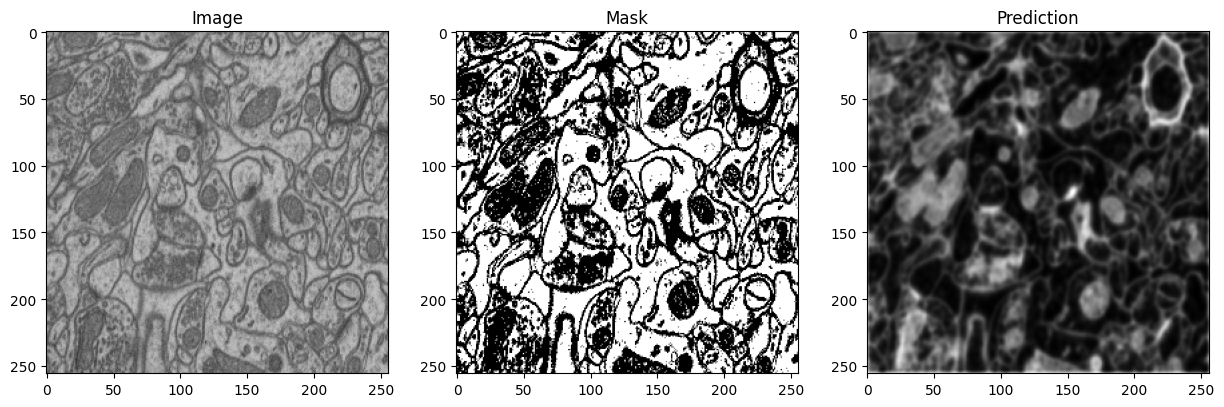

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


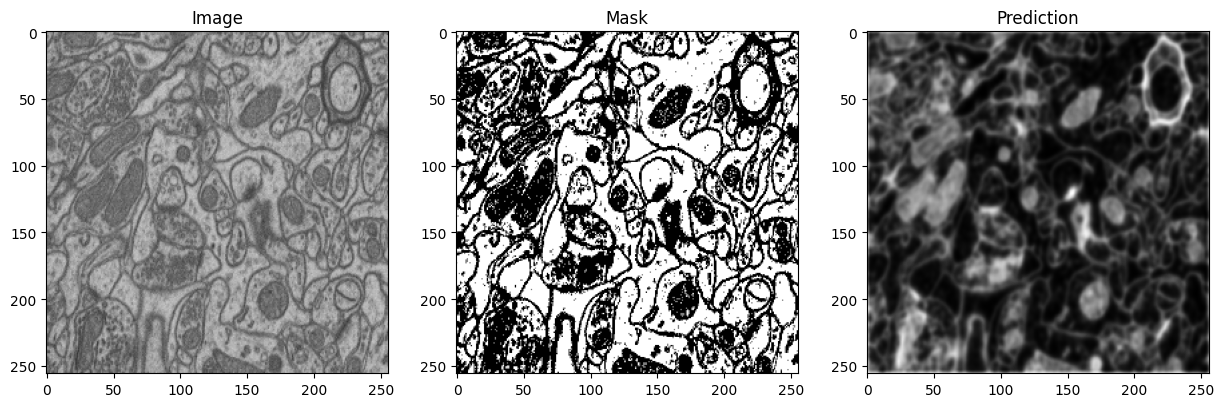

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


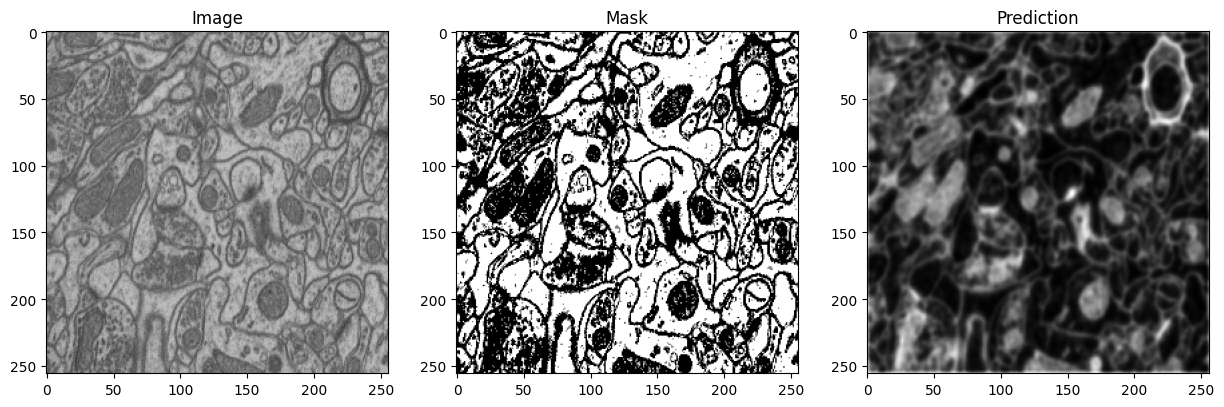

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


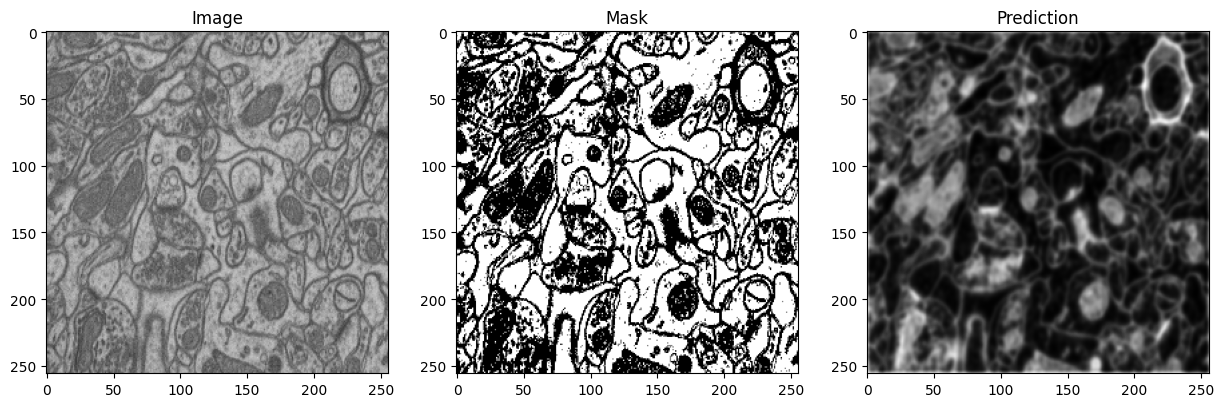

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


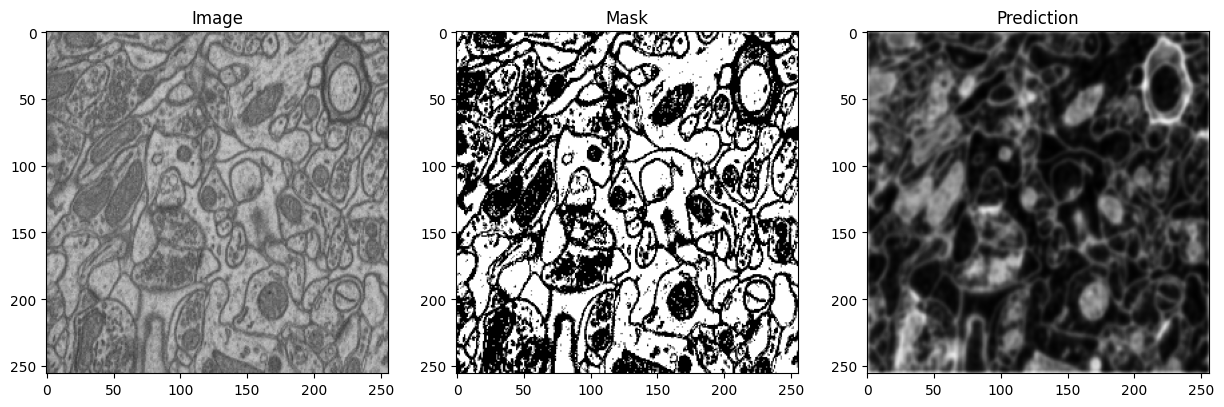

In [78]:
#Sample predictions
def plot_sample_predictions(images, masks, model, num_samples=5):
    for i in range(num_samples):
        image = images[i]
        mask = masks[i]
        prediction = model.predict(np.expand_dims(image, axis=0))[0]
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image.squeeze(), cmap='gray')
        ax[0].set_title('Image')
        ax[1].imshow(mask.squeeze(), cmap='gray')
        ax[1].set_title('Mask')
        ax[2].imshow(prediction.squeeze(), cmap='gray')
        ax[2].set_title('Prediction')
        plt.show()

plot_sample_predictions(test_images, test_masks, model)

**As we can see above, this model Jaccuard new loss does not perform as well as the first one at segmenting the mitochondria**

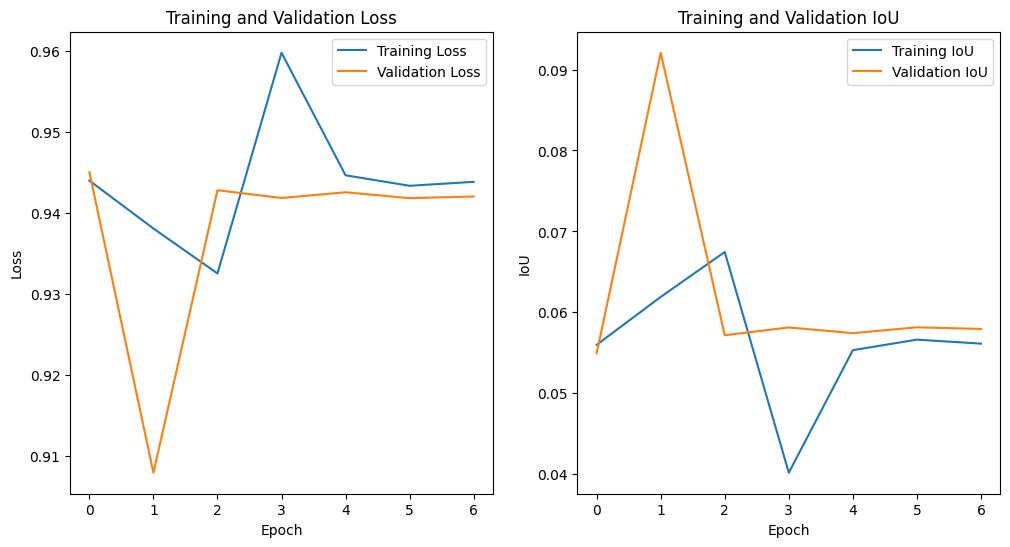

In [79]:
# Training history (loss and IoU metric)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()

